## **1. Introduction**
`wavesolve` is a lightweight package which can solve for the scalar and vector eigenmodes of waveguides using the finite-element method (specifically, Galerkin's method - read more <a href = "finite_element_method_notes.pdf"> here</a>.) The general workflow for `wavesolve` is the following:

1. Specify the waveguide boundaries (e.g. the outer cladding radius and the core radius for step-index optical fibers.) 
2. Create a mesh, that is contained/divided by the boundaries you specified.
3. Assign an index of refraction to each bounded area in the mesh.
4. Solve the generalized eigenvector problem associated with the waveguide mesh, giving the guided modes.

To implement the above, `wavesolve` provides the following submodules:

1. `waveguide`: a set of classes which can be used to generate meshes for arbitrary waveguides.
2. `fe_solver`: a set of functions used to solve for waveguide eigenmodes, taking finite element meshes as inputs.

**Section 2** goes over the `waveguide` submodule, while **Section 3** provides documentation for the `fe_solver` submodule.  **Section 4** includes some miscellaneous worked examples for photonic crystal fibers. **Section 5** contains the old version of the documentation, where meshes are generated using an alternate (and more limited) `mesher` submodule.


## **2. The `waveguide` module**

The `waveguide` module enables you to model 2D waveguide cross-sections.

<a id='sec2.1'></a>
### **2.1 Defining waveguides**

In this section we discuss how to build waveguides from the bottom-up. In practice, users may only need to interact with the high-level `Waveguide` class covered in Section 2.1.2.

<a id='sec2.1.1'></a>
#### **2.1.1 the `Prim2D` class**

The basic parent class that represents a refractive index geometry is a `Prim2D`. Each `Prim2D` stores a refractive index value and an array of $(x,y)$ points bounding the physical region which contains that index value. A `Prim2D` is generically initialized through

**`prim2D = waveguide.Prim2D(n,label,points)`**

**Arguments**

1.  `n` : the refractive index of the primitive. 

2. `label` : a string identifier to attach to the primitive (e.g. "core" or "cladding").

3. `points` (optional): an $N\times 2$ array of $(x,y)$ points corresponding to a material interface The first and last point are automatically connected. Default is `None`, since `points` can also be generated with functional dependence, as mentioned next.  

To make specific types of geometries, users are encouraged to define subclasses that inherit from `Prim2D` and generate `points` according to specific rules. These subclasses should implement their own `make_points()` functions, which at minimum should take in some set of arguments (like radius, for a circle primitive) and return the corresponding point array. Subclasses should also implement the following function

> `boundary_dist(x,y)` : compute the minimum distance between the point $(x,y)$ and the primitive boundary, returning a negative value if the point is inside the boundary. 

See the `Circle`, `Ellipse`, and `Rectangle` classes for examples. 

More complicated primitives can be created through `waveguide.Prim2DUnion`, representing a list of intersecting primitives, and `waveguide.Prim2DArray`, representing a list of non-intersecting primitives.

<a id='sec2.1.3'></a>
#### **2.1.2 the `Waveguide` class**

A `Waveguide` stores a (potentially nested) list of `Prim2D`s, which we will call `prim2Dgroups`. The refractive index profile of each top-level element in `prim2Dgroups` is overwritten by the immediate next element. An element in `prim2Dgroups` can also be a list of `Prim2D` objects; in this case all elements in the sublist override the refractive index profile of the previous element.$^\dagger$ So, an optical fiber might store its primitives as `[cladding,core]`, where `cladding` and `core` are `Pipe`s corresponding to the cladding and core regions; a multicore fiber could have the structure `[cladding,[core1,core2,...]]`. A `Waveguide` is generically initialized as 

**`wvg = Waveguide(prim2Dgroups)`**

**Arguments** 

1.  `prim2Dgroups` : the potentially nested list of 3D primitives mentioned above.

Like before, users are encouraged to define their own `Waveguide` subclasses, which initialize a set of `Prim2D` objects and arranges them as desired. The `Waveguide` class is mainly used to generate meshes, which can be tuned via `Waveguide` class attributes; see Section 2.2 for more details. For example `Waveguides`, check out the `CircularFiber` and `EllipticalFiber` classes. I have also implemented basic example classes for photonic crystal fibers; see Section 4.

$^\dagger$ `Prim2D` objects in the same sublist should never intersect. However, they can have different `label`s and refractive indices. If you want to model intersecting primitives, you should make a `Prim2DUnion`.

#### **2.1.3 the `Waveguide` class functions**

To get the refractive index dictionary of the waveguide, use `IOR_dict = Waveguide.assign_IOR()`. 

To view meshes, the `Waveguide` class implements `Waveguide.plot_mesh()`:

`Waveguide.plot_mesh()`

**Optional arguments**
1. `mesh`: the mesh to plot. If `None`, one is generated using default values through `make_mesh()`.
2. `IOR_dict`: dictionary of refractive index values. If `None`, one is generated through `assign_IOR()`.

#### **2.2 Mesh generation**

Mesh generation is primarily handled using

`Waveguide.make_mesh(algo,order,adaptive):`

**Arguments**

1. `algo` : the mesh generation algorithm used by Gmsh. The default `6` is good starting point.
2. `order` : the order of the finite elements. Order `1` (linear triangle) and `2` (quadratic triangle) are implemented; default `2`.

**Optional arguments**

3. `adaptive`: whether or not to refine mesh element sizes so that the mesh is most refined only at primitive boundaries; default `False`. 

When using the mode `adaptive=True`, a target mesh size is computed over the computation region as function of $(x,y)$. For a single `Prim2D` object, a target mesh size at a given $(x,y)$ point is computed as 

$$
{\rm target \, size} = d_0\left(1+ \dfrac{s \, d(x,y)}{d_0} \right)^p
$$
where $d_0$ is the "default" mesh size set by the resolution of the `Prim2D` boundary, $d(x,y)$ is the distance between the point $(x,y)$ and the primitive's boundary, and $s$ and $p$ are variables. The default values for both $s$ and $p$ are 1; higher values mean that mesh size will increase more rapidly away from the boundary. For multiple primitives, a target size is computed for each and the minimum size is taken. Then the target size is clipped between a minimum and maximum allowed value. This function is implemented in

`Waveguide.compute_mesh_size(x,y,_scale,_power,min_size,max_size)`

where the `_scale` and `_power` args correspond to $s$ and $p$. The parameter values for the adaptive scheme are set through the following `Waveguide` class attributes:

> `mesh_dist_scale` : $s$, the mesh boundary refinement linear distance scaling. Default 1

> `mesh_dist_power` : $p$, mesh boundary refinement power scaling. Default 1

> `min_mesh_size` : minimum allowed mesh size, default 0.1

> `max_mesh_size` : maximum allowed mesh size, default 10

Users can also specify a target mesh size, and toggle boundary refinement on a per-primitive basis. This is done through the following `Prim2D` attributes: 

> `mesh_size` : target mesh size within the boundary of the primitive (otherwise the mesh size is set by the scheme described above.)

> `skip_refinement` : whether or not mesh refinement should be applied at the primitive boundary. The outer boundary of the entire mesh should have this set to `True`; default `False`.


#### **2.3 Example: elliptical core fiber**
Below we use the `waveguide` module to make an elliptical fiber.

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


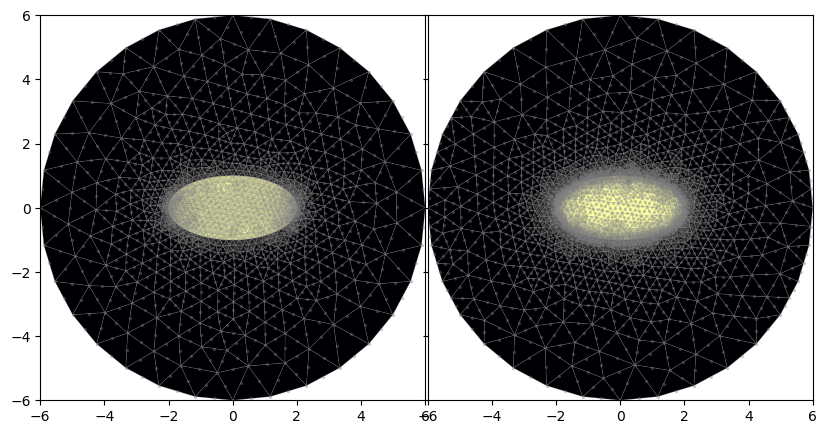

In [1]:
from wavesolve import waveguide
import matplotlib.pyplot as plt

## params 
ncore = 1.444+5e-2
nclad = 1.444
acore = 2. # extent of the elliptical core along the x axis
bcore = 1. # extent of the elliptical core along the y axis
rclad = 6. # cladding radius
res = 64 # resolution for core boundary

## make the fiber

# 1. first init a core object
core = waveguide.Ellipse(ncore,"core")

# 2. next generate the points
core.make_points(acore,bcore,res)

# 3. similarly, make a cladding object
clad = waveguide.Circle(nclad,"cladding")
clad.make_points(rclad,int(res/2))

# 4. now assemble into waveguide
fiber = waveguide.Waveguide([clad,core])

# 5. make the mesh - test both adaptive = False and True
mesh = fiber.make_mesh(adaptive=False)

fiber.mesh_dist_scale = 0.25 # lowering distance scale from default of 1.
mesh_ref = fiber.make_mesh(adaptive=True)

# 6. let's view meshes
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)

fiber.plot_mesh(mesh,ax=axs[0])
fiber.plot_mesh(mesh_ref,ax=axs[1])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

### 2.4 3-port photonic lantern cladding

For another example, I will generate a typical waveguide cross-section for a 3-port photonic lantern which is formed from tapering down a bundle of 3 single-mode fibers. The small end of this device typically has a flower-shaped cladding that can be approximated by 3 overlapping circles (each corresponding to one of the stock single-mode fibers in the bundle).

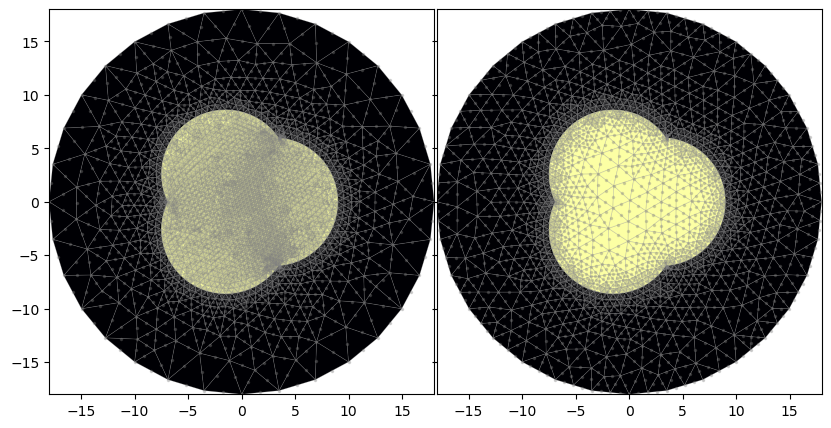

In [2]:
from wavesolve import waveguide
import matplotlib.pyplot as plt
import numpy as np

## params 
nclad = 1.444+5e-2
njack = 1.444

rclad = 6. # cladding radius
rjack = 18.
res = 64 # resolution for core boundary

rclad_offset = 3.

offsetsx = [1,np.cos(2*np.pi/3),np.cos(4*np.pi/3)]
offsetsy = [0,np.sin(2*np.pi/3),np.sin(4*np.pi/3)]
offsets = np.array([offsetsx,offsetsy]).T * rclad_offset

# make overlapping circular claddings
clads = []
for o in offsets:
    clad = waveguide.Circle(nclad,"cladding")
    clad.make_points(rclad,res,o)
    clads.append(clad)

# union
cladunion = waveguide.Prim2DUnion(clads,"cladding")

# make jacket
jacket = waveguide.Circle(njack,"jacket")
jacket.make_points(rjack,int(res/2))

# 4. now assemble into waveguide
PL = waveguide.Waveguide([jacket,cladunion])

# 5. make the mesh - test both adaptive = False and True
mesh = PL.make_mesh(adaptive=False)

PL.mesh_dist_scale = 0.25 # lowering distance scale from default of 1.
mesh_ref = PL.make_mesh(adaptive=True)

# 6. let's view meshes
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)

PL.plot_mesh(mesh,ax=axs[0])
PL.plot_mesh(mesh_ref,ax=axs[1])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

## **3. the `FEsolver` module**

This module takes meshes generated by `waveguide` and solves the corresponding generalized eigenvalue problem to get the waveguide eigenmodes. (This branch of) `wavesolve` can currently handles scalar modes.

### **3.1. Scalar modes**

A scalar mode assigns a scalar field amplitude at every node location in the mesh. ``wavesolve``'s scalar mode solver assumed quadratic triangle finite elements (``order=2``). 

#### 3.1.1. **Solving**

Given a finite element mesh, we can use the function `FEsolver.solve_waveguide()` to get the scalar eigenmodes. The signature is as follows:

**`solve_waveguide(mesh,wl,IOR_dict,plot=False,Nmax=6,target_neff=None)`**

**Arguments**

1. `mesh`: mesh object corresponding to waveguide geometry
2. `wl`: wavelength, defined in the same units as mesh point positions
3. `IOR_dict`: a dictionary assigning different named regions of the mesh different refractive index values
4. `plot`: set True to view eigenmodes
5. `Nmax`: return only the `Nmax` largest eigenvalue/eigenvector pairs
6. `target_neff`: expected effective index of the mode you want to solve for; autocomputed if `None`.

**Returns**
1. `w`: array of eigenvalues, descending order
2. `v`: array of corresponding eigenvectors (waveguide modes)
3. `N`: number of non-spurious eigenmodes.

#### 3.1.2. **Plotting**

To plot eigenmodes, use

`plot_scalar_mode(mesh,v,show_mesh,ax)`

**Arguments**
1.  `mesh`: finite element mesh
2.  `v`: an array (column vector) corresponding to an eigenmode
3.  `show_mesh`: set True to additionally plot the mesh geometry
4.  `ax`: optionally put the plot on a specific matplotlib axis

#### **3.1.3. Example - circular fiber**
In this example we generate a circular step-index fiber with the `waveguide` class. Then we generate an order 2 mesh and solve it using `solve_waveguide()`.

  Activating project at `c:\Users\jon88\miniconda3\envs\astro\lib\site-packages\wavesolve\FEsolver`


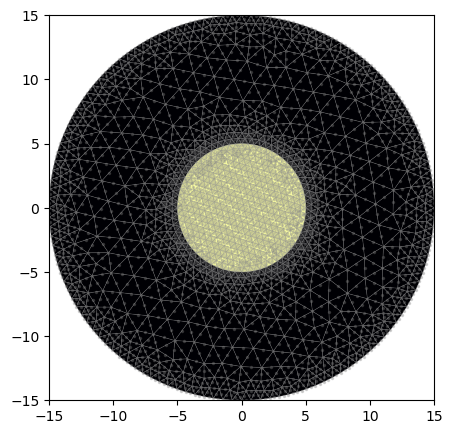

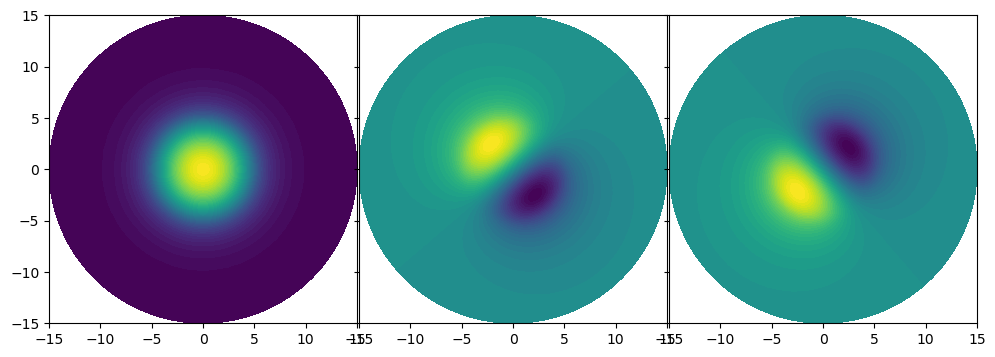

In [3]:
from wavesolve.FEsolver import solve_waveguide,plot_scalar_mode
from wavesolve import waveguide
import matplotlib.pyplot as plt

rcore = 5
rclad = 15
ncore = 1.444+8.8e-3
nclad = 1.444

# 3-mode fiber
circular_fiber = waveguide.CircularFiber(rcore,rclad,ncore,nclad,64,128,core_mesh_size=0.5)

wl = 1.55 #um
IOR_dict = circular_fiber.assign_IOR()
circular_fiber.mesh_dist_scale = 0.25
mesh = circular_fiber.make_mesh(order=2,adaptive=True)
circular_fiber.plot_mesh(mesh)

_w,_v,_n = solve_waveguide(mesh,wl,IOR_dict,Nmax=3)

fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))

for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_scalar_mode(mesh,_v[i],show_mesh=False,ax=ax)
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

#### **3.1.4. Evaluating and interpolating mode fields**

The ``FEsolver`` module provides some functions for evaluating fields which are defined on finite-element meshes. The evaluation is accelerated by sorting mesh triangles in a tree data structure, which is handled by the function ``FEsolver.sort_mesh()``.

**`sort_mesh(mesh)`**

**Arguments**

1. `mesh` : the mesh you want sorted

This returns the sorted `mesh` (which is also modified in-place, storing the tree data structure in `mesh.tree`).

To evaluate a field on a rectangular grid, we may use ``FEsolver.evaluate_grid()``. 

**`evaluate_grid(pointsx,pointsy,field,mesh)`**

**Arguments**

1. `pointsx` : 1D array of $x$ coordinates

2. `pointsx` : 1D array of $y$ coordinates

3. `field` : the electric field (e.g. an eigenmode) to be evaluated

4. `mesh` : the finite element mesh on which `field` is defined, assumed to be sorted.

This returns a 2D array, corresponding to `field` evaluated on the rectangular grid.

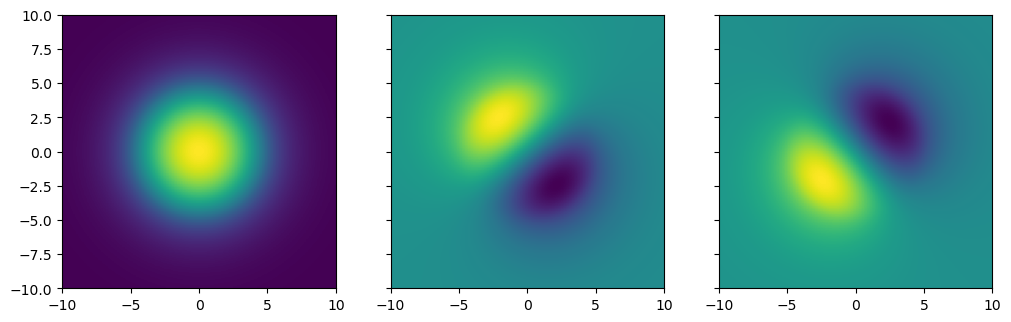

In [4]:
import numpy as np
from wavesolve.FEsolver import sort_mesh,evaluate_grid

sort_mesh(mesh) # sort the mesh. You only need to run this once.
xa = ya = np.linspace(-10,10,100) # make grid coordinate arrays, zoomed in a bit

fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))

for i,ax in enumerate(axs):
    _vgrid = evaluate_grid(xa,ya,_v[i],mesh)
    ax.set_aspect('equal')
    ax.imshow(_vgrid.T,origin="lower",extent=(-10,10,-10,10))

plt.show()

Pointwise evaluations can also be handled via ``FEsolver.evaluate``, for example

In [5]:
from wavesolve.FEsolver import evaluate

print(evaluate(np.array([0.,0.]),_v[0],mesh)) # one point
print(evaluate(np.array([[0.,0.],[1.,1.]]),_v[0],mesh)) # multiple points

0.1609102922813178
[0.16091029 0.15052994]


### 3.1.5 3-port PL mode solving

For fun, let's return to the earlier 3-port PL and find the modes.

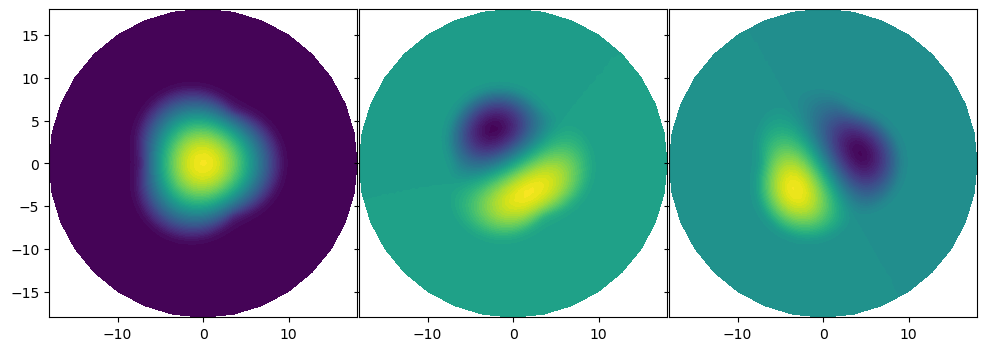

In [6]:
IOR_dict = PL.assign_IOR()
mesh = PL.make_mesh(adaptive=True)
_w,_v,_n = solve_waveguide(mesh,wl,IOR_dict,Nmax=3)

fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))

for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_scalar_mode(mesh,_v[i],show_mesh=False,ax=ax)
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

The modes look a little triangular!

### **3.2 Vector modes** (implementation in progress)

In `wavesolve`, vector modes are divided into transverse and longitudinal components. The longitudinal component is treated in the same way as a scalar mode, which has a defined value at every node position. In contrast, the transverse electric field is specified by assigning a value for the tangential electric field to every mesh edge (here "tangential" is with respect to the edge). This approach guarantees that the boundary conditions for Maxwell's equations are fulfilled. If $N_e$ is the number of mesh edges and $N_n$ is the number of nodes, a vector mode is an $(N_e+N_n)\times 1$ array whose first $N_e$ elements determine the transverse field and whose last $N_n$ components determine the longitudinal field.

#### **3.2.1. Solving**

To solve for the vector modes, we can use `FEsolver.solve_waveguide_vec()`. The vectorial solver is implemented for linear triangle elements (`order=1`). The call signature is the same as the scalar `solve_waveguide()`. 

**`solve_waveguide_vec(mesh,wl,IOR_dict,plot=False,Nmax=6,target_neff=None)`**

**Arguments**

1. `mesh`: mesh object corresponding to waveguide geometry
2. `wl`: wavelength, defined in the same units as mesh point positions
3. `IOR_dict`: a dictionary assigning different named regions of the mesh different refractive index values
4. `plot`: set True to view eigenmodes
5. `Nmax`: return only the `Nmax` largest eigenvalue/eigenvector pairs
6. `target_neff`: expected effective index of the mode you want to solve for; autocomputed if `None`.

**Returns**
1. `w`: array of eigenvalues, descending order
2. `v`: array of corresponding eigenvectors (waveguide modes)
3. `N`: number of non-spurious eigenmodes.

The default solving mode is to transform the generalized eigenproblem $A x =\lambda B x$ is transformed to $Cx = \lambda x$ where $C$ solves $BC = A$ ; this system is solved with ``Pardiso.jl``.

#### **3.2.2 Plotting**

To plot a vector eigenmode, use `plot_vector_mode()`, which has the same signature as `plot_scalar_mode()` but produces a quiver plot corresponding to the transverse component of the electric field. The longitudinal component can be plotted using `plot_scalar_mode()`. To access the transverse and longitudinal components of the vector, you will need to know the number of edges and points in your mesh. These values are stored in the attributes `mesh.num_edges` and `mesh.num_points`.

#### **3.2.3 Example: vector modes of circular fiber**

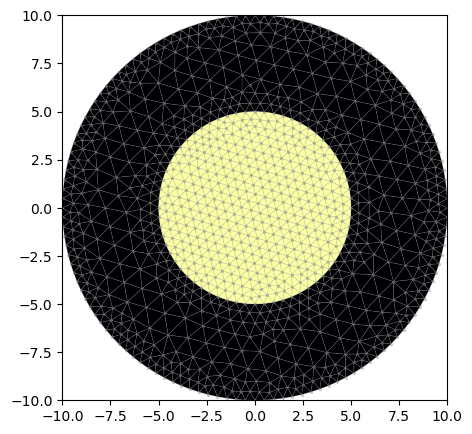

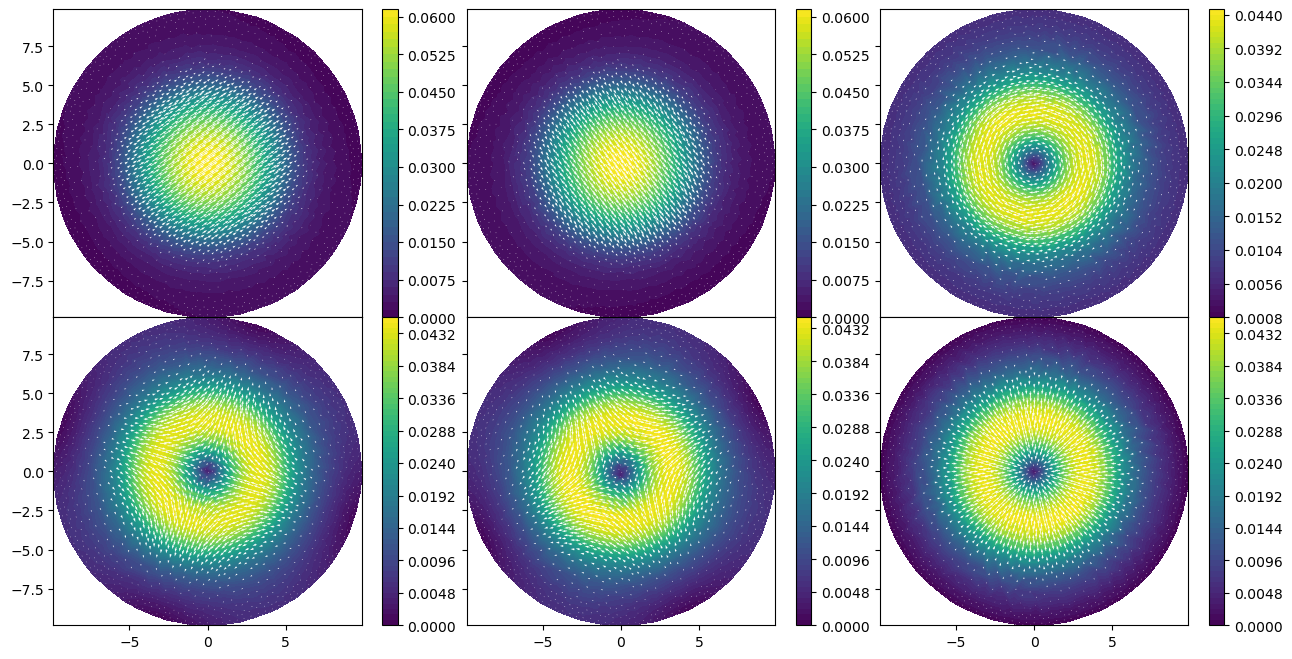

In [7]:
from wavesolve.FEsolver import solve_waveguide_vec,plot_vector_mode
from wavesolve import waveguide
import matplotlib.pyplot as plt

rcore=5
rclad = 10
ncore = 1.444+8.8e-3
nclad = 1.444

circular_fiber = waveguide.CircularFiber(rcore,rclad,ncore,nclad,64,128,core_mesh_size=0.5)

wl = 1.55 #um
IOR_dict = circular_fiber.assign_IOR()
circular_fiber.mesh_dist_scale = 0.25
mesh = circular_fiber.make_mesh(order=1,adaptive=True)
circular_fiber.plot_mesh(mesh)

_w,_v,_n = solve_waveguide_vec(mesh,wl,IOR_dict,plot=False,Nmax=6)
fig,axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,8))

for i,ax in enumerate(axs.flatten()):
    ax.set_aspect('equal')
    plot_vector_mode(mesh,_v[i],show_mesh=False,ax=ax)

plt.subplots_adjust(hspace=0,wspace=0)

plt.show()

## **4. Misc examples**

### **4.1 Index-guiding photonic crystal fiber**
A typical index-guiding photonic crystal fiber contains a cladding regularly perforated with air holes. A region of some characteric radius near the center of the fiber remains unperforated, and ultimately composes the "core" of the fiber. Below is an example. First, we'll make a mesh using the `PhotonicCrystalFiber` class. (When meshing adaptively, mesh generation takes longer for this structure because distances need to be every waveguide boundary.)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


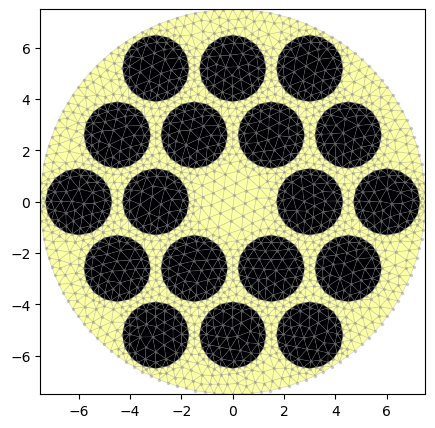

In [1]:
from wavesolve.waveguide import PhotonicCrystalFiber

hole_radius = 1.3
clad_radius = 7.5
hole_separation = 3.
nclad = 1.444
hole_res = 16
clad_res = 64
wl=1.55

PCF = PhotonicCrystalFiber(hole_radius,clad_radius,nclad,hole_separation,hole_res,clad_res,hole_mesh_size=1.0,clad_mesh_size=0.5)

m = PCF.make_mesh(order=1,adaptive=True)
PCF.plot_mesh(m)

Then, we'll use the vector solver to get the modes. This particular arrangement only has fundamental modes.

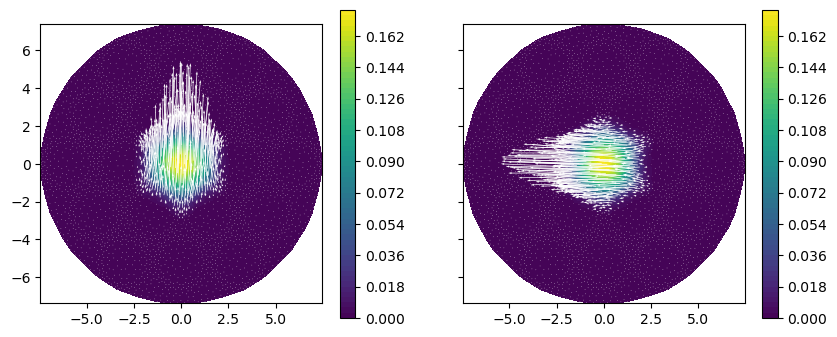

In [3]:
from wavesolve.FEsolver import plot_vector_mode,solve_waveguide_vec
import matplotlib.pyplot as plt

IOR_dict = PCF.assign_IOR()
w,v,n = solve_waveguide_vec(m,wl,IOR_dict,plot=False,Nmax=10)
fig,axs = plt.subplots(1,2,sharey=True,figsize=(10,4))
for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_vector_mode(m,v[i],ax=axs[i])
plt.show()

We'll also plot the longitudinal component of the electric field. This field is defined over the nodes of the mesh, so we can use `plot_scalar_mode()`.

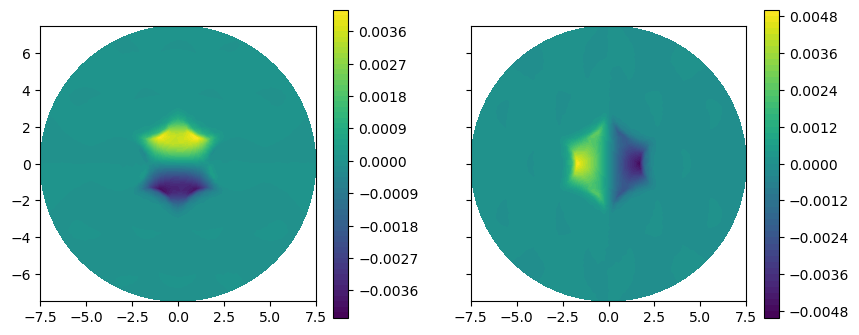

In [4]:
from wavesolve.FEsolver import plot_scalar_mode
import numpy as np

Ne = m.num_edges # number of mesh edges
fig,axs = plt.subplots(1,2,sharey=True,figsize=(10,4))

for i,ax in enumerate(axs):
    im = plot_scalar_mode(m,np.real(v[i,Ne:]),ax=ax) # the longitudinal components are at the end of the vector
    plt.colorbar(im, ax=ax, orientation='vertical')
plt.subplots_adjust(wspace=0.25)
plt.show()

We can also evaluate the vector-valued tangential component of the electric field over a rectangular grid, using the same ``evaluate_grid()`` function as before. When applied to vectorial electric fields, it returns two components, corresponding to the transverse and longitudinal electric field, respectively.

(The transposes and whatnot in ``imshow`` are to make sure the first axis of the image (row index) corresponds to $x$, which is on the horizontal, etc).

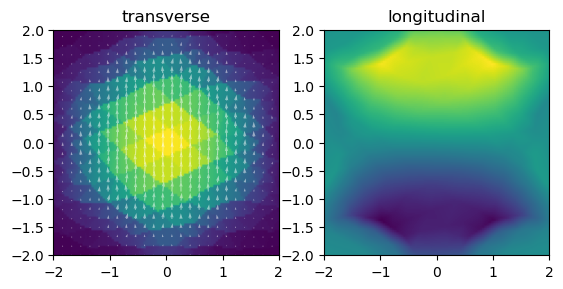

In [5]:
from wavesolve.FEsolver import evaluate_grid,sort_mesh
import numpy as np

sort_mesh(m)
xa = ya = np.linspace(-2,2,100)
xg,yg=np.meshgrid(xa,ya)
vt,vz = evaluate_grid(xa,ya,v[0],m)

vt_dec = vt[::4,::4,:]

fig,axs = plt.subplots(1,2)
axs[0].imshow(np.linalg.norm(vt,axis=2).T,extent=(xa[0],xa[-1],ya[0],ya[-1]),origin="lower") # plotting modulus
axs[0].quiver(xg[::4,::4],yg[::4,::4],vt_dec[:,:,0],vt_dec[:,:,1],color="white",width=0.005,alpha=0.5)

axs[1].imshow(np.real(vz).T,extent=(xa[0],xa[-1],ya[0],ya[-1]),origin="lower")

axs[0].set_title("transverse")
axs[1].set_title("longitudinal")

plt.show()

Like in the scalar case, we can also use ``FEsolver.evaluate`` to perform pointwise or 1D arraywise evaluations of a vectorial field.

In [6]:
from wavesolve.FEsolver import evaluate

print(evaluate(np.array([0.,0.]),v[0],m)) # one point
print(evaluate(np.array([[0.,0.],[1.,1.]]),v[0],m)) # multiple points

(array([0.00499952+0.j, 0.17761584+0.j]), array(-1.75464736e-07+0.j))
(array([[ 0.00499952+0.j,  0.17761584+0.j],
       [-0.0008062 +0.j,  0.08860757+0.j]]), array([-1.75464736e-07+0.j,  2.98025114e-03+0.j]))


Interestingly, the triangle boundaries of the mesh are visible. I think this is because the vector FEM approach we're using is edge-based, assigning a tangential component to the electric field along the edge of every triangle. Doing so ensures tangential continuity everywhere, but does not enforce normal (i.e. edge-perpendicular) continuity, so the modulus of the vector field is overall discontinuous. 

### **4.2 Hollow core photonic crystal fiber**
In contrast with index-guiding photonic crystal fibers, hollow core fibers guide light in a region that is typically of lower index than the waveguide material. In this case, guidance is provided by the so-called photonic bandgap, which is analogous the electronic gap between Brillouin zones in crystals. Such modes are trickier to model because they have lower effective index, and might be hard to distinguish from cladding modes. In these cases, you may have to search for modes by specifying a target effective index for the guided mode.

Below is an example. First we'll make the mesh.

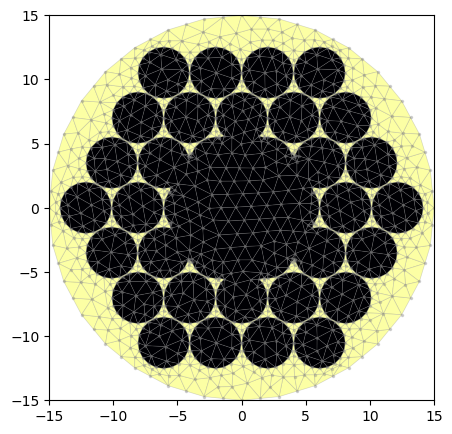

In [13]:
from wavesolve.waveguide import PhotonicBandgapFiber

# these specs are loosely based off the images I found of NKT hollow core fibers.
void_radius = 11.5/2
hole_radius = 2.
clad_radius = 15.
nclad = 1.444
hole_separation = 4.05

hollow_PCF = PhotonicBandgapFiber(void_radius,hole_radius,clad_radius,nclad,hole_separation,20,32,hole_mesh_size=1.2,clad_mesh_size=2.)
m = hollow_PCF.make_mesh(order=1,adaptive=True)
hollow_PCF.plot_mesh(m)

Next, let's solve. The voids in this fiber have index 1, so I will search for modes with the largest indices at and below 1.

(Actually I already ran this and found the fundamental modes had an index of 0.995, so I will cheat and use that value.)

effective indices:  [0.99499838-0.j 0.99497623-0.j]


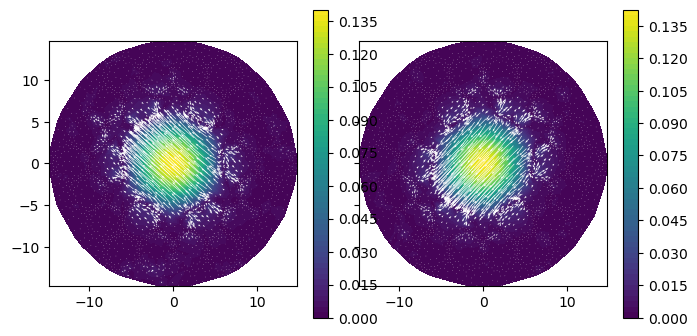

In [14]:
from wavesolve.FEsolver import get_eff_index,plot_vector_mode
import matplotlib.pyplot as plt

IOR_dict = hollow_PCF.assign_IOR()
wl = 1.65

w,v,n = solve_waveguide_vec(m,wl,IOR_dict,plot=False,target_neff=0.995,Nmax=2)

print("effective indices: ", get_eff_index(wl,w))

fig,axs = plt.subplots(1,2,sharey=True,figsize=(8,4))
for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_vector_mode(m,v[i],ax=axs[i])
plt.subplots_adjust(hspace=0,wspace=0)
plt.show()

Some nicer plots using interpolation to rectangular grid ...

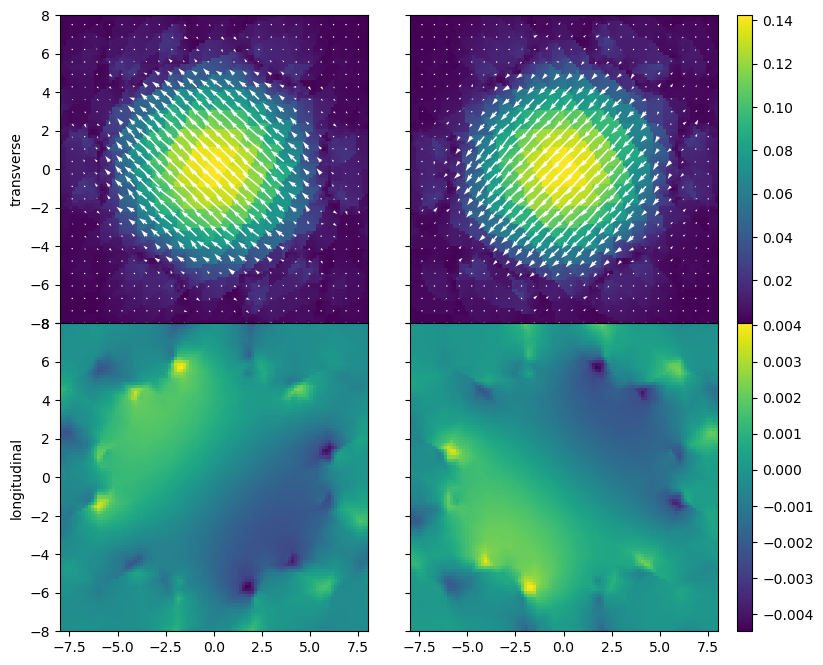

In [15]:
from wavesolve.FEsolver import evaluate_grid,sort_mesh
import numpy as np

sort_mesh(m)

xa = ya = np.linspace(-8,8,100)
xg,yg = np.meshgrid(xa,ya)
vt0,vz0 = evaluate_grid(xa,ya,v[0],m)
vt1,vz1 = evaluate_grid(xa,ya,v[1],m)

vt0_dec = vt0[::4,::4,:]
vt1_dec = vt1[::4,::4,:]

fig,axs = plt.subplots(2,2,sharey=True,sharex=True,figsize=(10,8))

axs[0,0].imshow(np.linalg.norm(vt0,axis=2).T,extent=(-8,8,-8,8),origin="lower")
axs[0,0].quiver(xg[::4,::4],yg[::4,::4],vt0_dec[:,:,0],vt0_dec[:,:,1],color='white',width=0.005)

im01 = axs[0,1].imshow(np.linalg.norm(vt1,axis=2).T,extent=(-8,8,-8,8),origin="lower")
axs[0,1].quiver(xg[::4,::4],yg[::4,::4],vt1_dec[:,:,0],vt1_dec[:,:,1],color='white',width=0.005)

axs[1,0].imshow(np.real(vz0).T,extent=(-8,8,-8,8),origin="lower")
im11 = axs[1,1].imshow(np.real(vz1).T,extent=(-8,8,-8,8),origin="lower")

axs[0,0].set_ylabel("transverse")
axs[1,0].set_ylabel("longitudinal")

plt.colorbar(im01,ax=axs[0,1])
plt.colorbar(im11,ax=axs[1,1])

plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

### **4.3 Known issues**

Below are some current issues in the code.

1. Mesh generation with `adaptive=True` takes a while, but is necessary for complex geometries. The main issue is scaling: as the complexity of the waveguide goes up, the number of boundaries goes up, and it becomes more expensive to determine the distance to the nearest waveguide boundary.
2. The doc sucks. I'll make a web doc soon ...